## Analysis of Models Home Credit - Credit Risk Model Stability

https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability

Contents:
- [Importing Data and Pre-Processing](#load_data)
- [Exploratory Analysis](#exp_analysis)
- [Train-Test Split](#train_test)
- [Fitting LightGBM Model](#model_lightgbm)

In [1]:
# import packages

import os
from dotenv import load_dotenv
from pyprojroot import here

# set working directory to root of github project for consistent access to helper functions
os.chdir(here())
# load .env variables
load_dotenv()

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats as st
import math
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
)

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
import shap

import snowflake.connector as sc

from elements.utils.data_processors import snake_case
from elements.utils.model_evaluation import (
    plot_feature_importance,
    classification_model_report,
)

pd.set_option("display.float_format", "{:.4f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# define feature columns

cont_features = [
    "static_monthly_annuity_amount",
    "static_next_month_annuity_amount",
    "static_count_apply_same_email",
    "static_count_apply_last_30_days",
    "static_count_apply_same_phone_number",
    "static_count_apply_same_employer",
    "static_count_apply_same_employer_last_7_days",
    "static_count_apply_same_mobile_phone_number",
    "static_avg_days_past_or_before_due_of_paymt_last_24_months",
    "static_avg_days_past_or_before_due_of_paymt_last_3_months",
    "static_avg_days_past_or_before_due_of_paymt_last_24_months_with_tolerance",
    "static_avg_days_past_due_of_paymt_last_24_months_with_tolerance_from_max_close_date",
    "static_avg_instals_paid_last_24_months",
    "avg_loan_amt_last_24_months",
    "avg_days_past_due_last_9_months",
    "static_avg_outstanding_bal_last_6_months",
    "static_avg_of_pays_made_last_12_months",
    "static_count_clients_have_used_same_mobile_number_last_12_months",
    "static_count_clients_have_used_same_mobile_number_last_3_months",
    "static_count_clients_have_used_same_mobile_number_last_6_months",
    "static_count_apply_match_employers_phone_and_clients",
    "static_count_clients_share_same_mobile_phone",
    "static_count_apply_match_client_alt_phone",
    "static_count_apply_client_match_alt_phone",
]

cat_features = [
    "static_type_of_bank_account",
    "static_type_of_credit_card",
]

# Importing Data and Pre-Processing
<a id='load_data'></a>

In [3]:
# initialize snowflake connector
conn = sc.connect(
    user=os.getenv("SNOWFLAKE_USERNAME"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    role=os.getenv("SNOWFLAKE_ROLE"),
    warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
)

In [4]:
# importing data set

modeling_case_default_prediction_df = pd.read_sql(
    "select * from credit_risk_dw.modeling.modeling_case_default_prediction",
    conn,
)

In [5]:
# lowercase columns

modeling_case_default_prediction_df.columns = [
    x.lower() for x in modeling_case_default_prediction_df.columns
]

In [6]:
# check import

modeling_case_default_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 35 columns):
 #   Column                                                                               Non-Null Count    Dtype  
---  ------                                                                               --------------    -----  
 0   case_model_group_key                                                                 1526659 non-null  object 
 1   case_id                                                                              1526659 non-null  int64  
 2   model_group                                                                          1526659 non-null  object 
 3   is_default                                                                           1526659 non-null  int64  
 4   decision_date                                                                        1526659 non-null  object 
 5   decision_month                                                        

In [7]:
modeling_case_default_prediction_df.is_default.value_counts()

0    1478665
1      47994
Name: is_default, dtype: int64

In [8]:
# pre-processing

for col in cat_features:

    modeling_case_default_prediction_df[col] = (
        modeling_case_default_prediction_df.apply(
            lambda x: snake_case(x[col]), axis=1
        )
    )

    # fill-in missing values

    modeling_case_default_prediction_df[col] = np.where(
        modeling_case_default_prediction_df[col].isnull(),
        "missing",
        modeling_case_default_prediction_df[col],
    )

# Exploratory Analysis
<a id='exp_analysis'></a>

In [9]:
# distribution by is_default for continuous features

# Train-Test Split
<a id='train_test'></a>

In [10]:
# train-test splits for validating final predictive model

y = modeling_case_default_prediction_df.is_default
X = modeling_case_default_prediction_df[cont_features + cat_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [11]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1068661, 26)
X_test shape: (457998, 26)


In [12]:
# resetting index is necessary for some re-merging later
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [13]:
# encoding categorical data into booleans for easier interpretation of feature importance

drop_binary_enc = OneHotEncoder(drop="if_binary", handle_unknown="ignore").fit(
    X_train.drop(cont_features, axis=1)
)

In [14]:
# creating dummy encoded datasets

dummy_df_train = pd.DataFrame(
    drop_binary_enc.transform(X_train.drop(cont_features, axis=1)).toarray(),
    columns=drop_binary_enc.get_feature_names(
        X_train.drop(cont_features, axis=1).columns
    ),
)

dummy_df_test = pd.DataFrame(
    drop_binary_enc.transform(X_test.drop(cont_features, axis=1)).toarray(),
    columns=drop_binary_enc.get_feature_names(
        X_test.drop(cont_features, axis=1).columns
    ),
)

In [15]:
# imputing medians for any missing numeric variables

for col in cont_features:
    imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
    imp_median.fit(X_train[col].values.reshape(-1, 1))

    X_train[col] = imp_median.transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = imp_median.transform(X_test[col].values.reshape(-1, 1))

In [16]:
# re-combining numeric and dummy encodings

transformed_df = pd.concat(
    [X_train[cont_features], dummy_df_train], axis=1
).reset_index(drop=True)
transformed_test = pd.concat(
    [X_test[cont_features], dummy_df_test], axis=1
).reset_index(drop=True)

In [17]:
# making sure all nulls were removed

print(transformed_df.columns[transformed_df.isnull().any()])
print(transformed_test.columns[transformed_test.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


# Fitting LightGBM Model
<a id='model_lightgbm'></a>

In [18]:
# fitting lightGBM classifier model

is_default_classifier = lgb.LGBMClassifier(
    seed=123,
    objective="binary",
    is_unbalance=True,
    n_estimators=300,
    num_leaves=100,
    max_depth=6,
    learning_rate=0.10,
    feature_fraction=0.60,
    bagging_freq=1,
    bagging_fraction=0.90,
    reg_alpha=0.025,
    reg_lambda=0.01,
    verbose=-1,
    importance_type="gain",
    deterministic=True,
)

is_default_classifier.fit(X=transformed_df, y=y_train)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, deterministic=True,
               feature_fraction=0.6, importance_type='gain', is_unbalance=True,
               max_depth=6, n_estimators=300, num_leaves=100,
               objective='binary', reg_alpha=0.025, reg_lambda=0.01, seed=123,
               verbose=-1)

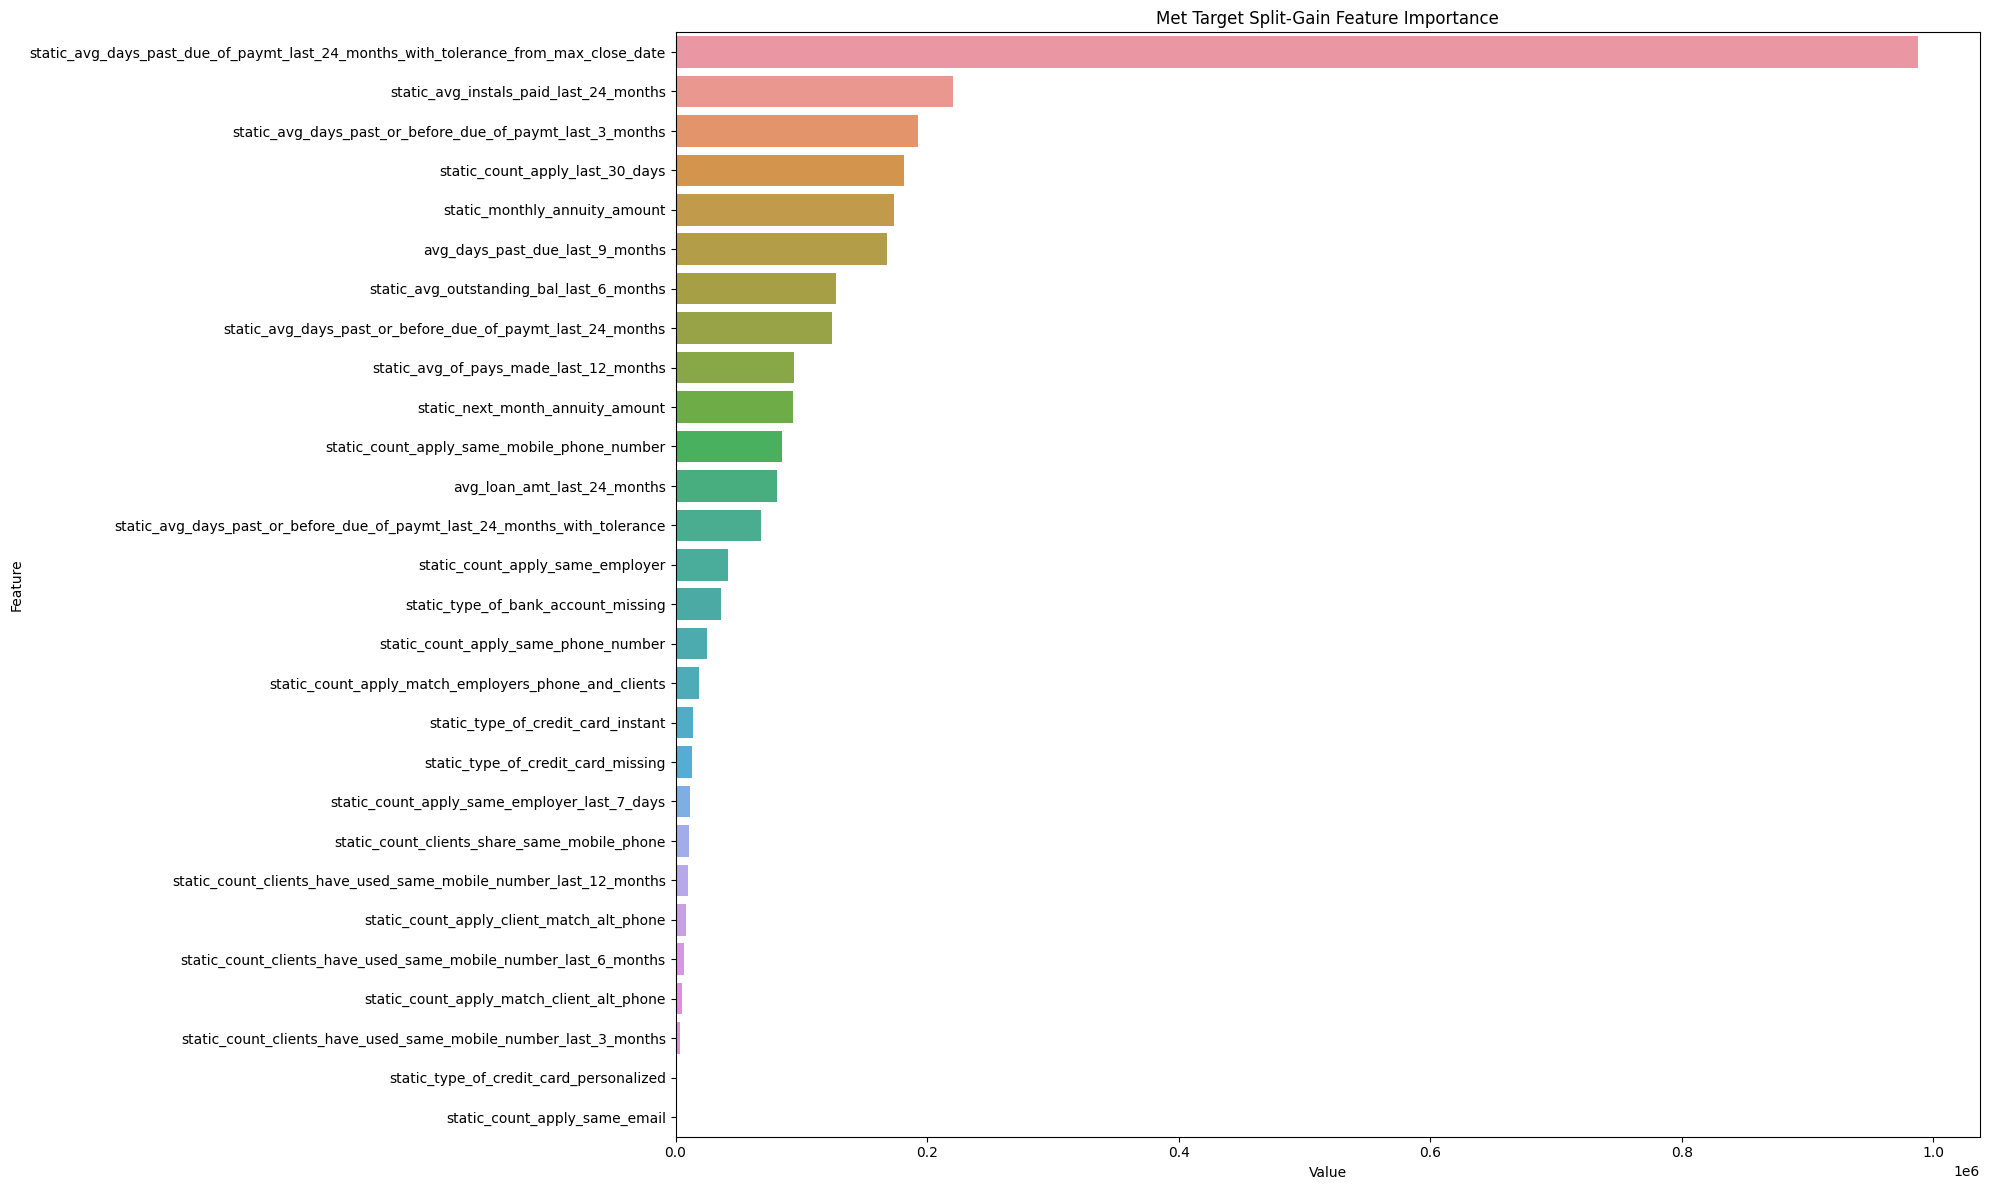

In [19]:
# plot split-gain feature importance from model
# this is a measure of feature importance in a predictive model obtained by calculated the improvement in
# accuracy for each feature in the branches of the underlying trees the feature is on

plot_feature_importance(
    feature_importance=is_default_classifier.feature_importances_,
    columns=transformed_df.columns,
    top_n=50,
    plot_width=20,
    plot_height=12,
    title="Met Target Split-Gain Feature Importance",
)